In [ ]:
%load_ext lab_black

In [ ]:
import datetime
import satdata
import satpy
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import rioxarray as rxr

# Downloading files

In [ ]:
t = datetime.datetime(day=2, month=2, year=2020, hour=14, minute=0)
dt_max = datetime.timedelta(minutes=20)

cli = satdata.Goes16AWS()

filenames = []
for channel in [1, 2, 3]:
    keys = cli.query(time=t, region="F", debug=True, dt_max=dt_max, channel=channel)
    fn = cli.download(keys[0])[0]
    filenames.append(fn)

Quering prefix `ABI-L1b-RadF/2020/033/13`


100%|██████████| 1/1 [00:34<00:00, 34.10s/it]


Quering prefix `ABI-L1b-RadF/2020/033/13`


100%|██████████| 1/1 [03:11<00:00, 191.76s/it]


Quering prefix `ABI-L1b-RadF/2020/033/13`


100%|██████████| 1/1 [00:48<00:00, 48.94s/it]


# Creating truecolor composites

In [ ]:
scene = satpy.Scene(filenames, reader="abi_l1b")

In [ ]:
# instruct satpy to load the channels necessary for the `true_color`
# composite
scene.load(["true_color"])

The following datasets were not created and may require resampling to be generated: DataID(name='true_color')


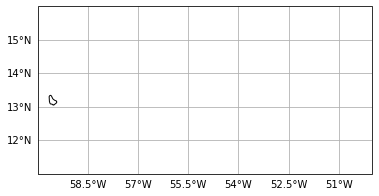

In [ ]:
BBOX = [-60, -50, 11, 16]  # WESN

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.set_extent(BBOX, crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=["left", "bottom"])
ax.coastlines()

In [ ]:
# satpy bbox: (xmin, ymin, xmax, ymax), WSEN
ll_bbox = [BBOX[0], BBOX[2], BBOX[1], BBOX[3]]
print(ll_bbox)
# ll_bbox = (-105.0, 40.0, -95.0, 50.0)
scene_cropped = scene.crop(ll_bbox=ll_bbox)

[-60, 11, -50, 16]


In [ ]:
# it is necessary to "resample" here because the different channels are at
# different spatial resolution. By not passing in an "area" the highest
# resolution possible will be used
new_scn = scene_cropped.resample(resampler="native")

In [ ]:
from satpy.writers import get_enhanced_image

In [ ]:
start_time = satdata.Goes16AWS.parse_key(filenames[0], parse_times=True)["start_time"]

In [ ]:
# make ISO8601 identifier
start_time_str = start_time.isoformat().replace("-", "").replace(":", "") + "Z"

In [ ]:
filename = f"GOES16_true_color_{start_time_str}.tif"

In [ ]:
new_scn.save_dataset("true_color", writer="geotiff", filename=filename)

/mnt/big/envs/envs/eurec4a-goes-truecolor-rgb-intake/lib/python3.9/site-packages/satpy/modifiers/angles.py:485: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)


In [ ]:
# Convert geotiff into netCDF file with RGB image data

In [ ]:
ds_ch1 = xr.open_dataset(filenames[0])

In [ ]:
# read tiff with rioxarray
da = rxr.open_rasterio(filename)

In [ ]:
# as data array

# remove attribute that we can't easily serialise
da2 = da.copy().drop("spatial_ref").expand_dims("t") / 255
# copy over projection info in a CF-compliant manner so that metpy can parse it
grid_mapping = ds_ch1.Rad.grid_mapping
da2.coords[grid_mapping] = ds_ch1[grid_mapping].drop(["t", "x_image", "y_image"])
da2.attrs["grid_mapping"] = grid_mapping
da2.name = "true_color"

da2.to_netcdf(filename.replace(".tif", ".nc"))